In [ ]:
from pathlib import Path
import numpy as np
import copy
import torch
import torchvision
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST, QMNIST
from torchvision.transforms.transforms import Resize
from typing import Any, Callable, Dict, List, Optional, Tuple
import os
import os.path
import pickle
from typing import Any, Callable, Optional, Tuple
import numpy as np
from PIL import Image
from torchvision.datasets.utils import check_integrity, download_and_extract_archive
from torchvision.datasets.vision import VisionDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

> **Architectures.** For experiments on CIFAR-10, CIFAR-100 and CINIC-10, we use a variant of ResNet-18 (He et al., 2016). We adapted the ResNet18 to 32x32 images by modifying the architecture to remove the downsampling effect. We replaced the spatial downsampling of a strided convolution and max pooling in the original ResNet18, with a convolutional layer with 64 filters and a kernel size of 3x3. We also removed the average pooling at the end of the ResNet18. This ResNet18 variant is similar to Resnet20, just with more filters

**Resnet Architecture as mentioned in paper:** [ https://github.com/OATML/RHO-Loss/blob/4c88851742ce5397153f4fef80abd4682958ac56/src/models/modules/resnet_cifar.py#L86 ]


In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes, self.expansion * planes, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])

def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

def resnet18_imagenet(pretrained=False, classes=10):
    model = torchvision.models.resnet18(pretrained=pretrained, num_classes=1000)
    model.conv1 = nn.Conv2d(
        3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
    )
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(512, classes, bias=True)
    return model

def resnet50_imagenet(pretrained=False, classes=10):
    model = torchvision.models.resnet50(pretrained=pretrained, num_classes=1000)
    model.fc = nn.Linear(512, classes, bias=True)
    return model

Data loading, data splitting code from: https://github.com/OATML/RHO-Loss/blob/main/src/datamodules/datamodules.py , https://github.com/OATML/RHO-Loss/blob/main/src/datamodules/datasets/sequence_datasets.py



In [ ]:
class indices_CIFAR10(VisionDataset):
    base_folder = "cifar-10-batches-py"
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar-10-python.tar.gz"
    tgz_md5 = "c58f30108f718f92721af3b95e74349a"
    train_list = [
        ["data_batch_1", "c99cafc152244af753f735de768cd75f"],
        ["data_batch_2", "d4bba439e000b95fd0a9bffe97cbabec"],
        ["data_batch_3", "54ebc095f3ab1f0389bbae665268c751"],
        ["data_batch_4", "634d18415352ddfa80567beed471001a"],
        ["data_batch_5", "482c414d41f54cd18b22e5b47cb7c3cb"],
    ]

    test_list = [
        ["test_batch", "40351d587109b95175f43aff81a1287e"],
    ]
    meta = {
        "filename": "batches.meta",
        "key": "label_names",
        "md5": "5ff9c542aee3614f3951f8cda6e48888",
    }

    def __init__(
        self,
        root: str,
        train: bool = True,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        sequence=None,
    ) -> None:

        super(indices_CIFAR10, self).__init__(
            root, transform=transform, target_transform=target_transform
        )

        self.train = train  # training set or test set

        self.download()

        if not self._check_integrity():
            raise RuntimeError(
                "Dataset not found or corrupted even though we tried to download it"
            )

        if self.train:
            downloaded_list = self.train_list
        else:
            downloaded_list = self.test_list

        self.data: Any = []
        self.targets = []

        # now load the picked numpy arrays
        for file_name, checksum in downloaded_list:
            file_path = os.path.join(self.root, self.base_folder, file_name)
            with open(file_path, "rb") as f:
                entry = pickle.load(f, encoding="latin1")
                self.data.append(entry["data"])
                if "labels" in entry:
                    self.targets.extend(entry["labels"])
                else:
                    self.targets.extend(entry["fine_labels"])

        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC

        self._load_meta()
        if sequence is not None:
            self.sequence = sequence
        else:
            self.sequence = np.arange(len(self.data))

    def _load_meta(self) -> None:
        path = os.path.join(self.root, self.base_folder, self.meta["filename"])
        if not check_integrity(path, self.meta["md5"]):
            raise RuntimeError("Dataset metadata file not found or corrupted")
        with open(path, "rb") as infile:
            data = pickle.load(infile, encoding="latin1")
            self.classes = data[self.meta["key"]]
        self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[self.sequence[index]], self.targets[self.sequence[index]]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return index, img, target

    def __len__(self) -> int:
        return len(self.sequence)

    def _check_integrity(self) -> bool:
        root = self.root
        for fentry in self.train_list + self.test_list:
            filename, md5 = fentry[0], fentry[1]
            fpath = os.path.join(root, self.base_folder, filename)
            if not check_integrity(fpath, md5):
                return False
        return True

    def download(self) -> None:
        if self._check_integrity():
            print("Files already downloaded and verified")
            return
        download_and_extract_archive(
            self.url, self.root, filename=self.filename, md5=self.tgz_md5
        )

    def extra_repr(self) -> str:
        return "Split: {}".format("Train" if self.train is True else "Test")

class CIFAR10DataModule:
    def __init__(self, data_dir="./data", batch_size=960, test_batch_size=100, num_workers=4):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.test_batch_size = test_batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        self.data_aug_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

    def setup(self, double_irlomo=False):
        full_dataset = indices_CIFAR10(self.data_dir, train=True, transform=self.data_aug_transform)

        indices = list(range(len(full_dataset)))
        train_indices = indices[::2]
        val_indices = indices[1::2]

        self.train_split_1 = Subset(full_dataset, train_indices)
        self.train_split_2 = Subset(full_dataset, val_indices)
        self.train_split_2_indices = val_indices  # needed for irreducible loss tracking

        self.test_dataset = indices_CIFAR10(self.data_dir, train=False, transform=self.transform)

    def get_train_loader_split1(self):
        return DataLoader(self.train_split_1, batch_size=128, shuffle=True, num_workers=self.num_workers)

    def get_train_loader_split2(self):
        return DataLoader(self.train_split_2, batch_size=1, shuffle=False, num_workers=self.num_workers)

    def get_test_loader(self):
        return DataLoader(self.test_dataset, batch_size=self.test_batch_size, shuffle=False, num_workers=self.num_workers)




**Training IL Model:**

> **Data augmentation:** On CIFAR-10, CIFAR-100, and CINIC-10, we train using data augmentation (random crop and horizontal flip), both for training the IL model, and in the main training runs. Remember that we only compute the irreducible losses once at the start of training.

> We can efficiently compute the IL with an “irreducible loss model" (IL model) that is smaller than the target model and has low accuracy . ResNet18 IL model trained for 37x fewer steps than each target model.

Irreducible loss models can be small and cheap. In our
default setting, both the target model and IL model have the same architecture (ResNet-18).The smaller IL model accelerates training as much or more than the larger model, even though its final accuracy is far lower than the target ResNet18 (11.5% lower on CIFAR-10, 7% on CIFAR-100, and 8.1% on CINIC-10).



In [ ]:
# === CONTINUATION CODE: RHO-LOSS Training on CIFAR-10 ===

import torch
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm, trange
import random
import warnings
warnings.filterwarnings("ignore")

# ====== Set device and seed ======
torch.manual_seed(42)
random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====== Initialize DataModule and Prepare Splits ======
dm = CIFAR10DataModule()
dm.setup()

train_loader_il = dm.get_train_loader_split1()
eval_loader_il = dm.get_train_loader_split2()
test_loader = dm.get_test_loader()
train_ids = dm.train_split_2_indices

# ====== Step 1: Train IL Model ======
il_model = ResNet18().to(device)
il_optimizer = optim.AdamW(il_model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

for epoch in trange(30, desc="Training IL Model"):
    il_model.train()
    correct, total = 0, 0
    for _, x, y in train_loader_il:
        x, y = x.to(device), y.to(device)
        il_optimizer.zero_grad()
        logits = il_model(x)
        loss = criterion(logits, y)
        loss.backward()
        il_optimizer.step()
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    acc = 100.0 * correct / total
    print(f"[IL Model] Epoch {epoch+1}: Accuracy = {acc:.2f}%")
    if acc >= 65.0:
        break

100%|██████████| 170M/170M [00:04<00:00, 34.6MB/s]


Files already downloaded and verified


Training IL Model:   3%|▎         | 1/30 [00:21<10:24, 21.52s/it]

[IL Model] Epoch 1: Accuracy = 41.89%


Training IL Model:   7%|▋         | 2/30 [00:41<09:43, 20.85s/it]

[IL Model] Epoch 2: Accuracy = 58.76%


Training IL Model:   7%|▋         | 2/30 [01:03<14:52, 31.87s/it]

[IL Model] Epoch 3: Accuracy = 66.54%


**Compute Irreducible Loss**

In [ ]:
print("Computing irreducible loss on split_2...")
il_model.eval()
irreducible_loss = {}
with torch.no_grad():
    for idx, (_, x, y) in tqdm(zip(train_ids, eval_loader_il), total=len(train_ids), desc="Computing IL"):
        x, y = x.to(device), y.to(device)
        loss = F.cross_entropy(il_model(x), y).item()
        irreducible_loss[idx] = loss

Computing irreducible loss on split_2...


Computing IL: 100%|██████████| 25000/25000 [02:29<00:00, 166.76it/s]


**Training Target Model with RHO-LOSS**

> **Hyperparameters:** All models are trained using the AdamW optimizer with default PyTorch hyperparameters (β1=0.9, β2=0.999, and weight decay of 0.01, learning rate 0.001), a nb = 32 ( nB = 320 , meaning we select nB/nb = 10% of points.We use between 2 and 10 seeds for each experiment


In [ ]:
# ====== Step 3: Train Target Model with RHO-LOSS ======
target_model = ResNet18().to(device)
target_optimizer = optim.AdamW(target_model.parameters(), lr=1e-3)
topk = 32
reached_80 = reached_875 = False

for epoch in trange(1, 300, desc="Training Target Model"):
    target_model.train()
    random.shuffle(train_ids)
    for i in range(0, len(train_ids), 320):
        ids = train_ids[i:i+320]
        x_b, y_b, il_b = [], [], []
        for idx in ids:
            _, x, y = dm.train_split_2.dataset[idx]
            x_b.append(x)
            y_b.append(y)
            il_b.append(irreducible_loss[idx])

        if len(x_b) < topk:
            continue  # skip if batch too small

        x_tensor = torch.stack(x_b).to(device)
        y_tensor = torch.tensor(y_b).to(device)
        il_tensor = torch.tensor(il_b).to(device)

        logits = target_model(x_tensor)
        losses = F.cross_entropy(logits, y_tensor, reduction='none')
        rho = losses - il_tensor
        top_indices = torch.topk(rho, topk).indices
        selected_loss = losses[top_indices].mean()

        target_optimizer.zero_grad()
        selected_loss.backward()
        target_optimizer.step()

    # ====== Evaluate on Test Set ======
    target_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for _, x, y in test_loader:
            x, y = x.to(device), y.to(device)
            pred = target_model(x).argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    acc = 100.0 * correct / total
    print(f"[Target Model] Epoch {epoch}: Accuracy = {acc:.2f}%")
    if not reached_80 and acc >= 80.0:
        print(f"✅ Reached 80% at epoch {epoch}")
        reached_80 = True
    if not reached_875 and acc >= 87.5:
        print(f"✅ Reached 87.5% at epoch {epoch}")
        reached_875 = True
    if reached_80 and reached_875:
        break

Training Target Model:   0%|          | 1/299 [00:22<1:53:44, 22.90s/it]

[Target Model] Epoch 1: Accuracy = 32.71%


Training Target Model:   1%|          | 2/299 [00:45<1:52:43, 22.77s/it]

[Target Model] Epoch 2: Accuracy = 42.83%


Training Target Model:   1%|          | 3/299 [01:08<1:52:45, 22.86s/it]

[Target Model] Epoch 3: Accuracy = 45.96%


Training Target Model:   1%|▏         | 4/299 [01:31<1:53:12, 23.02s/it]

[Target Model] Epoch 4: Accuracy = 44.66%


Training Target Model:   2%|▏         | 5/299 [01:55<1:53:43, 23.21s/it]

[Target Model] Epoch 5: Accuracy = 48.82%


Training Target Model:   2%|▏         | 6/299 [02:18<1:53:53, 23.32s/it]

[Target Model] Epoch 6: Accuracy = 61.57%


Training Target Model:   2%|▏         | 7/299 [02:42<1:53:27, 23.31s/it]

[Target Model] Epoch 7: Accuracy = 62.06%


Training Target Model:   3%|▎         | 8/299 [03:05<1:52:41, 23.24s/it]

[Target Model] Epoch 8: Accuracy = 62.78%


Training Target Model:   3%|▎         | 9/299 [03:28<1:51:57, 23.16s/it]

[Target Model] Epoch 9: Accuracy = 66.68%


Training Target Model:   3%|▎         | 10/299 [03:51<1:51:15, 23.10s/it]

[Target Model] Epoch 10: Accuracy = 63.67%


Training Target Model:   4%|▎         | 11/299 [04:14<1:50:36, 23.04s/it]

[Target Model] Epoch 11: Accuracy = 67.46%


Training Target Model:   4%|▍         | 12/299 [04:37<1:50:06, 23.02s/it]

[Target Model] Epoch 12: Accuracy = 71.39%


Training Target Model:   4%|▍         | 13/299 [05:00<1:49:38, 23.00s/it]

[Target Model] Epoch 13: Accuracy = 71.39%


Training Target Model:   5%|▍         | 14/299 [05:23<1:50:06, 23.18s/it]

[Target Model] Epoch 14: Accuracy = 72.16%


Training Target Model:   5%|▌         | 15/299 [05:46<1:49:26, 23.12s/it]

[Target Model] Epoch 15: Accuracy = 70.96%


Training Target Model:   5%|▌         | 16/299 [06:09<1:49:16, 23.17s/it]

[Target Model] Epoch 16: Accuracy = 70.44%


Training Target Model:   6%|▌         | 17/299 [06:33<1:49:28, 23.29s/it]

[Target Model] Epoch 17: Accuracy = 74.18%


Training Target Model:   6%|▌         | 18/299 [06:57<1:49:28, 23.38s/it]

[Target Model] Epoch 18: Accuracy = 73.74%


Training Target Model:   6%|▋         | 19/299 [07:20<1:48:58, 23.35s/it]

[Target Model] Epoch 19: Accuracy = 73.75%


Training Target Model:   7%|▋         | 20/299 [07:43<1:48:21, 23.30s/it]

[Target Model] Epoch 20: Accuracy = 73.83%


Training Target Model:   7%|▋         | 21/299 [08:06<1:47:35, 23.22s/it]

[Target Model] Epoch 21: Accuracy = 74.35%


Training Target Model:   7%|▋         | 22/299 [08:29<1:46:52, 23.15s/it]

[Target Model] Epoch 22: Accuracy = 76.39%


Training Target Model:   8%|▊         | 23/299 [08:52<1:46:16, 23.10s/it]

[Target Model] Epoch 23: Accuracy = 75.72%


Training Target Model:   8%|▊         | 24/299 [09:15<1:45:43, 23.07s/it]

[Target Model] Epoch 24: Accuracy = 75.50%


Training Target Model:   8%|▊         | 25/299 [09:38<1:45:09, 23.03s/it]

[Target Model] Epoch 25: Accuracy = 76.06%


Training Target Model:   9%|▊         | 26/299 [10:01<1:44:39, 23.00s/it]

[Target Model] Epoch 26: Accuracy = 74.08%


Training Target Model:   9%|▉         | 27/299 [10:24<1:44:31, 23.06s/it]

[Target Model] Epoch 27: Accuracy = 76.81%


Training Target Model:   9%|▉         | 28/299 [10:48<1:44:42, 23.18s/it]

[Target Model] Epoch 28: Accuracy = 75.31%


Training Target Model:  10%|▉         | 29/299 [11:11<1:44:47, 23.29s/it]

[Target Model] Epoch 29: Accuracy = 77.80%


Training Target Model:  10%|█         | 30/299 [11:34<1:44:24, 23.29s/it]

[Target Model] Epoch 30: Accuracy = 77.29%


Training Target Model:  10%|█         | 31/299 [11:57<1:43:38, 23.20s/it]

[Target Model] Epoch 31: Accuracy = 77.21%


Training Target Model:  11%|█         | 32/299 [12:20<1:42:58, 23.14s/it]

[Target Model] Epoch 32: Accuracy = 78.66%


Training Target Model:  11%|█         | 33/299 [12:43<1:42:18, 23.08s/it]

[Target Model] Epoch 33: Accuracy = 78.08%


Training Target Model:  11%|█▏        | 34/299 [13:06<1:41:41, 23.03s/it]

[Target Model] Epoch 34: Accuracy = 77.36%


Training Target Model:  12%|█▏        | 35/299 [13:29<1:41:11, 23.00s/it]

[Target Model] Epoch 35: Accuracy = 77.20%


Training Target Model:  12%|█▏        | 36/299 [13:52<1:40:46, 22.99s/it]

[Target Model] Epoch 36: Accuracy = 79.89%


Training Target Model:  12%|█▏        | 37/299 [14:15<1:40:22, 22.99s/it]

[Target Model] Epoch 37: Accuracy = 76.34%


Training Target Model:  13%|█▎        | 38/299 [14:38<1:40:28, 23.10s/it]

[Target Model] Epoch 38: Accuracy = 78.93%


Training Target Model:  13%|█▎        | 39/299 [15:02<1:40:43, 23.24s/it]

[Target Model] Epoch 39: Accuracy = 79.47%


Training Target Model:  13%|█▎        | 40/299 [15:26<1:40:37, 23.31s/it]

[Target Model] Epoch 40: Accuracy = 79.23%


Training Target Model:  14%|█▎        | 41/299 [15:49<1:40:14, 23.31s/it]

[Target Model] Epoch 41: Accuracy = 80.08%
✅ Reached 80% at epoch 41


Training Target Model:  14%|█▍        | 42/299 [16:12<1:39:30, 23.23s/it]

[Target Model] Epoch 42: Accuracy = 79.30%


Training Target Model:  14%|█▍        | 43/299 [16:35<1:38:47, 23.15s/it]

[Target Model] Epoch 43: Accuracy = 78.93%


Training Target Model:  15%|█▍        | 44/299 [16:58<1:38:10, 23.10s/it]

[Target Model] Epoch 44: Accuracy = 80.15%


Training Target Model:  15%|█▌        | 45/299 [17:21<1:37:37, 23.06s/it]

[Target Model] Epoch 45: Accuracy = 79.65%


Training Target Model:  15%|█▌        | 46/299 [17:44<1:37:08, 23.04s/it]

[Target Model] Epoch 46: Accuracy = 81.00%


Training Target Model:  16%|█▌        | 47/299 [18:07<1:36:43, 23.03s/it]

[Target Model] Epoch 47: Accuracy = 77.92%


In [ ]:
# ====== Step 3: Train Target Model with RHO-LOSS → Margin Sampling ======
torch.manual_seed(42)
random.seed(42)
target_model = ResNet18().to(device)
target_optimizer = optim.AdamW(target_model.parameters(), lr=1e-3)
topk = 32
reached_80 = reached_875 = False

for epoch in trange(1, 300, desc="Training Target Model"):
    target_model.train()
    random.shuffle(train_ids)

    for i in range(0, len(train_ids), 320):
        ids = train_ids[i:i+320]
        x_b, y_b, il_b = [], [], []
        for idx in ids:
            _, x, y = dm.train_split_2.dataset[idx]
            x_b.append(x)
            y_b.append(y)
            il_b.append(irreducible_loss[idx])

        if len(x_b) < 100:
            continue  # Ensure we can select top-100 for margin sampling

        x_tensor = torch.stack(x_b).to(device)
        y_tensor = torch.tensor(y_b).to(device)
        il_tensor = torch.tensor(il_b).to(device)

        # Compute RHO
        logits = target_model(x_tensor)
        losses = F.cross_entropy(logits, y_tensor, reduction='none')
        rho = losses - il_tensor

        # === Stage 1: Select top 100 by RHO ===
        top100_indices = torch.topk(rho, 100).indices
        x_top100 = x_tensor[top100_indices]
        y_top100 = y_tensor[top100_indices]
        losses_top100 = losses[top100_indices]

        # === Stage 2: Margin Sampling ===
        with torch.no_grad():
            probs = F.softmax(target_model(x_top100), dim=1)
            sorted_probs, _ = probs.sort(descending=True)
            margins = sorted_probs[:, 0] - sorted_probs[:, 1]  # Smaller = more ambiguous

        top32_margin = torch.topk(-margins, 32).indices  # Select 32 most ambiguous
        final_indices = top100_indices[top32_margin]  # Map back to original 320 batch

        selected_loss = losses[final_indices].mean()

        target_optimizer.zero_grad()
        selected_loss.backward()
        target_optimizer.step()

    # ====== Evaluate on Test Set ======
    target_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for _, x, y in test_loader:
            x, y = x.to(device), y.to(device)
            pred = target_model(x).argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    acc = 100.0 * correct / total
    print(f"[Target Model] Epoch {epoch}: Accuracy = {acc:.2f}%")
    if not reached_80 and acc >= 80.0:
        print(f"✅ Reached 80% at epoch {epoch}")
        reached_80 = True
    if not reached_875 and acc >= 87.5:
        print(f"✅ Reached 87.5% at epoch {epoch}")
        reached_875 = True
    if reached_80 and reached_875:
        break


Training Target Model:   0%|          | 1/299 [00:24<2:01:34, 24.48s/it]

[Target Model] Epoch 1: Accuracy = 35.31%


Training Target Model:   1%|          | 2/299 [00:49<2:03:47, 25.01s/it]

[Target Model] Epoch 2: Accuracy = 37.83%


Training Target Model:   1%|          | 3/299 [01:14<2:02:37, 24.86s/it]

[Target Model] Epoch 3: Accuracy = 43.22%


Training Target Model:   1%|▏         | 4/299 [01:39<2:01:29, 24.71s/it]

[Target Model] Epoch 4: Accuracy = 43.89%


Training Target Model:   2%|▏         | 5/299 [02:03<2:01:13, 24.74s/it]

[Target Model] Epoch 5: Accuracy = 50.83%


Training Target Model:   2%|▏         | 6/299 [02:28<2:00:56, 24.77s/it]

[Target Model] Epoch 6: Accuracy = 50.93%


Training Target Model:   2%|▏         | 7/299 [02:53<2:00:11, 24.70s/it]

[Target Model] Epoch 7: Accuracy = 55.48%


Training Target Model:   3%|▎         | 8/299 [03:17<1:59:40, 24.68s/it]

[Target Model] Epoch 8: Accuracy = 56.38%


Training Target Model:   3%|▎         | 9/299 [03:42<1:59:22, 24.70s/it]

[Target Model] Epoch 9: Accuracy = 59.66%


Training Target Model:   3%|▎         | 10/299 [04:07<1:58:55, 24.69s/it]

[Target Model] Epoch 10: Accuracy = 61.65%


Training Target Model:   4%|▎         | 11/299 [04:31<1:58:32, 24.69s/it]

[Target Model] Epoch 11: Accuracy = 65.77%


Training Target Model:   4%|▍         | 12/299 [04:56<1:58:22, 24.75s/it]

[Target Model] Epoch 12: Accuracy = 64.18%


Training Target Model:   4%|▍         | 13/299 [05:21<1:58:25, 24.84s/it]

[Target Model] Epoch 13: Accuracy = 66.78%


Training Target Model:   5%|▍         | 14/299 [05:47<1:58:49, 25.02s/it]

[Target Model] Epoch 14: Accuracy = 60.84%


Training Target Model:   5%|▌         | 15/299 [06:12<1:58:47, 25.10s/it]

[Target Model] Epoch 15: Accuracy = 66.51%


Training Target Model:   5%|▌         | 16/299 [06:37<1:58:37, 25.15s/it]

[Target Model] Epoch 16: Accuracy = 68.33%


Training Target Model:   6%|▌         | 17/299 [07:02<1:58:02, 25.12s/it]

[Target Model] Epoch 17: Accuracy = 72.15%


Training Target Model:   6%|▌         | 18/299 [07:27<1:57:01, 24.99s/it]

[Target Model] Epoch 18: Accuracy = 72.48%


Training Target Model:   6%|▋         | 19/299 [07:52<1:56:06, 24.88s/it]

[Target Model] Epoch 19: Accuracy = 71.84%


Training Target Model:   7%|▋         | 20/299 [08:16<1:55:29, 24.84s/it]

[Target Model] Epoch 20: Accuracy = 73.13%


Training Target Model:   7%|▋         | 21/299 [08:41<1:54:48, 24.78s/it]

[Target Model] Epoch 21: Accuracy = 72.48%


Training Target Model:   7%|▋         | 22/299 [09:06<1:54:11, 24.74s/it]

[Target Model] Epoch 22: Accuracy = 73.30%


Training Target Model:   8%|▊         | 23/299 [09:30<1:53:43, 24.72s/it]

[Target Model] Epoch 23: Accuracy = 74.86%


Training Target Model:   8%|▊         | 24/299 [09:55<1:53:17, 24.72s/it]

[Target Model] Epoch 24: Accuracy = 74.34%


Training Target Model:   8%|▊         | 25/299 [10:20<1:52:49, 24.71s/it]

[Target Model] Epoch 25: Accuracy = 75.00%


Training Target Model:   9%|▊         | 26/299 [10:45<1:52:25, 24.71s/it]

[Target Model] Epoch 26: Accuracy = 73.65%


Training Target Model:   9%|▉         | 27/299 [11:09<1:52:00, 24.71s/it]

[Target Model] Epoch 27: Accuracy = 75.33%


Training Target Model:   9%|▉         | 28/299 [11:34<1:51:36, 24.71s/it]

[Target Model] Epoch 28: Accuracy = 73.76%


Training Target Model:  10%|▉         | 29/299 [11:59<1:51:10, 24.71s/it]

[Target Model] Epoch 29: Accuracy = 77.17%


Training Target Model:  10%|█         | 30/299 [12:23<1:50:45, 24.71s/it]

[Target Model] Epoch 30: Accuracy = 76.29%


Training Target Model:  10%|█         | 31/299 [12:48<1:50:55, 24.83s/it]

[Target Model] Epoch 31: Accuracy = 77.04%


Training Target Model:  11%|█         | 32/299 [13:14<1:50:57, 24.93s/it]

[Target Model] Epoch 32: Accuracy = 76.60%


Training Target Model:  11%|█         | 33/299 [13:39<1:51:08, 25.07s/it]

[Target Model] Epoch 33: Accuracy = 77.30%


Training Target Model:  11%|█▏        | 34/299 [14:04<1:51:05, 25.15s/it]

[Target Model] Epoch 34: Accuracy = 75.44%


Training Target Model:  12%|█▏        | 35/299 [14:30<1:50:46, 25.17s/it]

[Target Model] Epoch 35: Accuracy = 79.31%


Training Target Model:  12%|█▏        | 36/299 [14:55<1:50:03, 25.11s/it]

[Target Model] Epoch 36: Accuracy = 77.71%


Training Target Model:  12%|█▏        | 37/299 [15:19<1:49:18, 25.03s/it]

[Target Model] Epoch 37: Accuracy = 78.79%


Training Target Model:  13%|█▎        | 38/299 [15:44<1:48:28, 24.94s/it]

[Target Model] Epoch 38: Accuracy = 77.25%


Training Target Model:  13%|█▎        | 39/299 [16:09<1:47:45, 24.87s/it]

[Target Model] Epoch 39: Accuracy = 78.40%


Training Target Model:  13%|█▎        | 40/299 [16:34<1:47:09, 24.82s/it]

[Target Model] Epoch 40: Accuracy = 78.68%


Training Target Model:  14%|█▎        | 41/299 [16:58<1:46:39, 24.80s/it]

[Target Model] Epoch 41: Accuracy = 78.84%


Training Target Model:  14%|█▍        | 42/299 [17:23<1:46:06, 24.77s/it]

[Target Model] Epoch 42: Accuracy = 79.92%


Training Target Model:  14%|█▍        | 43/299 [17:48<1:45:37, 24.76s/it]

[Target Model] Epoch 43: Accuracy = 79.40%


Training Target Model:  15%|█▍        | 44/299 [18:12<1:45:06, 24.73s/it]

[Target Model] Epoch 44: Accuracy = 80.52%
✅ Reached 80% at epoch 44


Training Target Model:  15%|█▌        | 45/299 [18:37<1:44:33, 24.70s/it]

[Target Model] Epoch 45: Accuracy = 78.71%


Training Target Model:  15%|█▌        | 46/299 [19:02<1:43:59, 24.66s/it]

[Target Model] Epoch 46: Accuracy = 79.45%


Training Target Model:  16%|█▌        | 47/299 [19:26<1:43:27, 24.63s/it]

[Target Model] Epoch 47: Accuracy = 79.62%


Training Target Model:  16%|█▌        | 48/299 [19:51<1:43:01, 24.63s/it]

[Target Model] Epoch 48: Accuracy = 78.45%


Training Target Model:  16%|█▋        | 49/299 [20:16<1:42:57, 24.71s/it]

[Target Model] Epoch 49: Accuracy = 80.09%


Training Target Model:  17%|█▋        | 50/299 [20:41<1:43:00, 24.82s/it]

[Target Model] Epoch 50: Accuracy = 80.54%


Training Target Model:  17%|█▋        | 51/299 [21:06<1:43:12, 24.97s/it]

[Target Model] Epoch 51: Accuracy = 80.27%


Training Target Model:  17%|█▋        | 52/299 [21:31<1:43:05, 25.04s/it]

[Target Model] Epoch 52: Accuracy = 80.63%


Training Target Model:  18%|█▊        | 53/299 [21:56<1:42:45, 25.06s/it]

[Target Model] Epoch 53: Accuracy = 80.63%


Training Target Model:  18%|█▊        | 54/299 [22:21<1:42:22, 25.07s/it]

[Target Model] Epoch 54: Accuracy = 81.51%


Training Target Model:  18%|█▊        | 55/299 [22:46<1:41:40, 25.00s/it]

[Target Model] Epoch 55: Accuracy = 79.36%


Training Target Model:  19%|█▊        | 56/299 [23:11<1:40:47, 24.89s/it]

[Target Model] Epoch 56: Accuracy = 80.96%


Training Target Model:  19%|█▉        | 57/299 [23:36<1:40:02, 24.80s/it]

[Target Model] Epoch 57: Accuracy = 81.14%


Training Target Model:  19%|█▉        | 58/299 [24:00<1:39:25, 24.75s/it]

[Target Model] Epoch 58: Accuracy = 81.08%


Training Target Model:  20%|█▉        | 59/299 [24:25<1:38:52, 24.72s/it]

[Target Model] Epoch 59: Accuracy = 81.65%


Training Target Model:  20%|██        | 60/299 [24:49<1:38:21, 24.69s/it]

[Target Model] Epoch 60: Accuracy = 78.59%


Training Target Model:  20%|██        | 61/299 [25:14<1:37:48, 24.66s/it]

[Target Model] Epoch 61: Accuracy = 81.89%


Training Target Model:  21%|██        | 62/299 [25:39<1:37:17, 24.63s/it]

[Target Model] Epoch 62: Accuracy = 80.28%


Training Target Model:  21%|██        | 62/299 [25:46<1:38:32, 24.95s/it]


KeyboardInterrupt: 

In [7]:
import re

def extract_accuracies(log_text: str) :
    """
    Extracts all floating‑point numbers immediately following 'Accuracy =' in the log.
    Works for lines like:
      [Epoch   1] Test Accuracy = 25.48%
      Epoch 10: Accuracy = 52.55%
    """
    pattern = r"Accuracy\s*=\s*([\d\.]+)%"
    return [float(m.group(1)) for m in re.finditer(pattern, log_text)]
# --- Example usage ---
if __name__ == "__main__":
    log_str = """Training Target Model:   0%|          | 1/299 [00:22<1:53:44, 22.90s/it][Target Model] Epoch 1: Accuracy = 32.71%
Training Target Model:   1%|          | 2/299 [00:45<1:52:43, 22.77s/it][Target Model] Epoch 2: Accuracy = 42.83%
Training Target Model:   1%|          | 3/299 [01:08<1:52:45, 22.86s/it][Target Model] Epoch 3: Accuracy = 45.96%
Training Target Model:   1%|▏         | 4/299 [01:31<1:53:12, 23.02s/it][Target Model] Epoch 4: Accuracy = 44.66%
Training Target Model:   2%|▏         | 5/299 [01:55<1:53:43, 23.21s/it][Target Model] Epoch 5: Accuracy = 48.82%
Training Target Model:   2%|▏         | 6/299 [02:18<1:53:53, 23.32s/it][Target Model] Epoch 6: Accuracy = 61.57%
Training Target Model:   2%|▏         | 7/299 [02:42<1:53:27, 23.31s/it][Target Model] Epoch 7: Accuracy = 62.06%
Training Target Model:   3%|▎         | 8/299 [03:05<1:52:41, 23.24s/it][Target Model] Epoch 8: Accuracy = 62.78%
Training Target Model:   3%|▎         | 9/299 [03:28<1:51:57, 23.16s/it][Target Model] Epoch 9: Accuracy = 66.68%
Training Target Model:   3%|▎         | 10/299 [03:51<1:51:15, 23.10s/it][Target Model] Epoch 10: Accuracy = 63.67%
Training Target Model:   4%|▎         | 11/299 [04:14<1:50:36, 23.04s/it][Target Model] Epoch 11: Accuracy = 67.46%
Training Target Model:   4%|▍         | 12/299 [04:37<1:50:06, 23.02s/it][Target Model] Epoch 12: Accuracy = 71.39%
Training Target Model:   4%|▍         | 13/299 [05:00<1:49:38, 23.00s/it][Target Model] Epoch 13: Accuracy = 71.39%
Training Target Model:   5%|▍         | 14/299 [05:23<1:50:06, 23.18s/it][Target Model] Epoch 14: Accuracy = 72.16%
Training Target Model:   5%|▌         | 15/299 [05:46<1:49:26, 23.12s/it][Target Model] Epoch 15: Accuracy = 70.96%
Training Target Model:   5%|▌         | 16/299 [06:09<1:49:16, 23.17s/it][Target Model] Epoch 16: Accuracy = 70.44%
Training Target Model:   6%|▌         | 17/299 [06:33<1:49:28, 23.29s/it][Target Model] Epoch 17: Accuracy = 74.18%
Training Target Model:   6%|▌         | 18/299 [06:57<1:49:28, 23.38s/it][Target Model] Epoch 18: Accuracy = 73.74%
Training Target Model:   6%|▋         | 19/299 [07:20<1:48:58, 23.35s/it][Target Model] Epoch 19: Accuracy = 73.75%
Training Target Model:   7%|▋         | 20/299 [07:43<1:48:21, 23.30s/it][Target Model] Epoch 20: Accuracy = 73.83%
Training Target Model:   7%|▋         | 21/299 [08:06<1:47:35, 23.22s/it][Target Model] Epoch 21: Accuracy = 74.35%
Training Target Model:   7%|▋         | 22/299 [08:29<1:46:52, 23.15s/it][Target Model] Epoch 22: Accuracy = 76.39%
Training Target Model:   8%|▊         | 23/299 [08:52<1:46:16, 23.10s/it][Target Model] Epoch 23: Accuracy = 75.72%
Training Target Model:   8%|▊         | 24/299 [09:15<1:45:43, 23.07s/it][Target Model] Epoch 24: Accuracy = 75.50%
Training Target Model:   8%|▊         | 25/299 [09:38<1:45:09, 23.03s/it][Target Model] Epoch 25: Accuracy = 76.06%
Training Target Model:   9%|▊         | 26/299 [10:01<1:44:39, 23.00s/it][Target Model] Epoch 26: Accuracy = 74.08%
Training Target Model:   9%|▉         | 27/299 [10:24<1:44:31, 23.06s/it][Target Model] Epoch 27: Accuracy = 76.81%
Training Target Model:   9%|▉         | 28/299 [10:48<1:44:42, 23.18s/it][Target Model] Epoch 28: Accuracy = 75.31%
Training Target Model:  10%|▉         | 29/299 [11:11<1:44:47, 23.29s/it][Target Model] Epoch 29: Accuracy = 77.80%
Training Target Model:  10%|█         | 30/299 [11:34<1:44:24, 23.29s/it][Target Model] Epoch 30: Accuracy = 77.29%
Training Target Model:  10%|█         | 31/299 [11:57<1:43:38, 23.20s/it][Target Model] Epoch 31: Accuracy = 77.21%
Training Target Model:  11%|█         | 32/299 [12:20<1:42:58, 23.14s/it][Target Model] Epoch 32: Accuracy = 78.66%
Training Target Model:  11%|█         | 33/299 [12:43<1:42:18, 23.08s/it][Target Model] Epoch 33: Accuracy = 78.08%
Training Target Model:  11%|█▏        | 34/299 [13:06<1:41:41, 23.03s/it][Target Model] Epoch 34: Accuracy = 77.36%
Training Target Model:  12%|█▏        | 35/299 [13:29<1:41:11, 23.00s/it][Target Model] Epoch 35: Accuracy = 77.20%
Training Target Model:  12%|█▏        | 36/299 [13:52<1:40:46, 22.99s/it][Target Model] Epoch 36: Accuracy = 79.89%
Training Target Model:  12%|█▏        | 37/299 [14:15<1:40:22, 22.99s/it][Target Model] Epoch 37: Accuracy = 76.34%
Training Target Model:  13%|█▎        | 38/299 [14:38<1:40:28, 23.10s/it][Target Model] Epoch 38: Accuracy = 78.93%
Training Target Model:  13%|█▎        | 39/299 [15:02<1:40:43, 23.24s/it][Target Model] Epoch 39: Accuracy = 79.47%
Training Target Model:  13%|█▎        | 40/299 [15:26<1:40:37, 23.31s/it][Target Model] Epoch 40: Accuracy = 79.23%
Training Target Model:  14%|█▎        | 41/299 [15:49<1:40:14, 23.31s/it][Target Model] Epoch 41: Accuracy = 80.08%
✅ Reached 80% at epoch 41"""
    rho_accuracies = extract_accuracies(log_str)
    print(rho_accuracies)

[32.71, 42.83, 45.96, 44.66, 48.82, 61.57, 62.06, 62.78, 66.68, 63.67, 67.46, 71.39, 71.39, 72.16, 70.96, 70.44, 74.18, 73.74, 73.75, 73.83, 74.35, 76.39, 75.72, 75.5, 76.06, 74.08, 76.81, 75.31, 77.8, 77.29, 77.21, 78.66, 78.08, 77.36, 77.2, 79.89, 76.34, 78.93, 79.47, 79.23, 80.08]


In [8]:
import re

def extract_accuracies(log_text: str) :
    """
    Extracts all floating‑point numbers immediately following 'Accuracy =' in the log.
    Works for lines like:
      [Epoch   1] Test Accuracy = 25.48%
      Epoch 10: Accuracy = 52.55%
    """
    pattern = r"Accuracy\s*=\s*([\d\.]+)%"
    return [float(m.group(1)) for m in re.finditer(pattern, log_text)]
# --- Example usage ---
if __name__ == "__main__":
    log_str = """Training Target Model:   0%|          | 1/299 [00:24<2:01:34, 24.48s/it][Target Model] Epoch 1: Accuracy = 35.31%
Training Target Model:   1%|          | 2/299 [00:49<2:03:47, 25.01s/it][Target Model] Epoch 2: Accuracy = 37.83%
Training Target Model:   1%|          | 3/299 [01:14<2:02:37, 24.86s/it][Target Model] Epoch 3: Accuracy = 43.22%
Training Target Model:   1%|▏         | 4/299 [01:39<2:01:29, 24.71s/it][Target Model] Epoch 4: Accuracy = 43.89%
Training Target Model:   2%|▏         | 5/299 [02:03<2:01:13, 24.74s/it][Target Model] Epoch 5: Accuracy = 50.83%
Training Target Model:   2%|▏         | 6/299 [02:28<2:00:56, 24.77s/it][Target Model] Epoch 6: Accuracy = 50.93%
Training Target Model:   2%|▏         | 7/299 [02:53<2:00:11, 24.70s/it][Target Model] Epoch 7: Accuracy = 55.48%
Training Target Model:   3%|▎         | 8/299 [03:17<1:59:40, 24.68s/it][Target Model] Epoch 8: Accuracy = 56.38%
Training Target Model:   3%|▎         | 9/299 [03:42<1:59:22, 24.70s/it][Target Model] Epoch 9: Accuracy = 59.66%
Training Target Model:   3%|▎         | 10/299 [04:07<1:58:55, 24.69s/it][Target Model] Epoch 10: Accuracy = 61.65%
Training Target Model:   4%|▎         | 11/299 [04:31<1:58:32, 24.69s/it][Target Model] Epoch 11: Accuracy = 65.77%
Training Target Model:   4%|▍         | 12/299 [04:56<1:58:22, 24.75s/it][Target Model] Epoch 12: Accuracy = 64.18%
Training Target Model:   4%|▍         | 13/299 [05:21<1:58:25, 24.84s/it][Target Model] Epoch 13: Accuracy = 66.78%
Training Target Model:   5%|▍         | 14/299 [05:47<1:58:49, 25.02s/it][Target Model] Epoch 14: Accuracy = 60.84%
Training Target Model:   5%|▌         | 15/299 [06:12<1:58:47, 25.10s/it][Target Model] Epoch 15: Accuracy = 66.51%
Training Target Model:   5%|▌         | 16/299 [06:37<1:58:37, 25.15s/it][Target Model] Epoch 16: Accuracy = 68.33%
Training Target Model:   6%|▌         | 17/299 [07:02<1:58:02, 25.12s/it][Target Model] Epoch 17: Accuracy = 72.15%
Training Target Model:   6%|▌         | 18/299 [07:27<1:57:01, 24.99s/it][Target Model] Epoch 18: Accuracy = 72.48%
Training Target Model:   6%|▋         | 19/299 [07:52<1:56:06, 24.88s/it][Target Model] Epoch 19: Accuracy = 71.84%
Training Target Model:   7%|▋         | 20/299 [08:16<1:55:29, 24.84s/it][Target Model] Epoch 20: Accuracy = 73.13%
Training Target Model:   7%|▋         | 21/299 [08:41<1:54:48, 24.78s/it][Target Model] Epoch 21: Accuracy = 72.48%
Training Target Model:   7%|▋         | 22/299 [09:06<1:54:11, 24.74s/it][Target Model] Epoch 22: Accuracy = 73.30%
Training Target Model:   8%|▊         | 23/299 [09:30<1:53:43, 24.72s/it][Target Model] Epoch 23: Accuracy = 74.86%
Training Target Model:   8%|▊         | 24/299 [09:55<1:53:17, 24.72s/it][Target Model] Epoch 24: Accuracy = 74.34%
Training Target Model:   8%|▊         | 25/299 [10:20<1:52:49, 24.71s/it][Target Model] Epoch 25: Accuracy = 75.00%
Training Target Model:   9%|▊         | 26/299 [10:45<1:52:25, 24.71s/it][Target Model] Epoch 26: Accuracy = 73.65%
Training Target Model:   9%|▉         | 27/299 [11:09<1:52:00, 24.71s/it][Target Model] Epoch 27: Accuracy = 75.33%
Training Target Model:   9%|▉         | 28/299 [11:34<1:51:36, 24.71s/it][Target Model] Epoch 28: Accuracy = 73.76%
Training Target Model:  10%|▉         | 29/299 [11:59<1:51:10, 24.71s/it][Target Model] Epoch 29: Accuracy = 77.17%
Training Target Model:  10%|█         | 30/299 [12:23<1:50:45, 24.71s/it][Target Model] Epoch 30: Accuracy = 76.29%
Training Target Model:  10%|█         | 31/299 [12:48<1:50:55, 24.83s/it][Target Model] Epoch 31: Accuracy = 77.04%
Training Target Model:  11%|█         | 32/299 [13:14<1:50:57, 24.93s/it][Target Model] Epoch 32: Accuracy = 76.60%
Training Target Model:  11%|█         | 33/299 [13:39<1:51:08, 25.07s/it][Target Model] Epoch 33: Accuracy = 77.30%
Training Target Model:  11%|█▏        | 34/299 [14:04<1:51:05, 25.15s/it][Target Model] Epoch 34: Accuracy = 75.44%
Training Target Model:  12%|█▏        | 35/299 [14:30<1:50:46, 25.17s/it][Target Model] Epoch 35: Accuracy = 79.31%
Training Target Model:  12%|█▏        | 36/299 [14:55<1:50:03, 25.11s/it][Target Model] Epoch 36: Accuracy = 77.71%
Training Target Model:  12%|█▏        | 37/299 [15:19<1:49:18, 25.03s/it][Target Model] Epoch 37: Accuracy = 78.79%
Training Target Model:  13%|█▎        | 38/299 [15:44<1:48:28, 24.94s/it][Target Model] Epoch 38: Accuracy = 77.25%
Training Target Model:  13%|█▎        | 39/299 [16:09<1:47:45, 24.87s/it][Target Model] Epoch 39: Accuracy = 78.40%
Training Target Model:  13%|█▎        | 40/299 [16:34<1:47:09, 24.82s/it][Target Model] Epoch 40: Accuracy = 78.68%
Training Target Model:  14%|█▎        | 41/299 [16:58<1:46:39, 24.80s/it][Target Model] Epoch 41: Accuracy = 78.84%
Training Target Model:  14%|█▍        | 42/299 [17:23<1:46:06, 24.77s/it][Target Model] Epoch 42: Accuracy = 79.92%
Training Target Model:  14%|█▍        | 43/299 [17:48<1:45:37, 24.76s/it][Target Model] Epoch 43: Accuracy = 79.40%
Training Target Model:  15%|█▍        | 44/299 [18:12<1:45:06, 24.73s/it][Target Model] Epoch 44: Accuracy = 80.52%
✅ Reached 80% at epoch 44"""
    ma_accuracies = extract_accuracies(log_str)
    print(ma_accuracies)

[35.31, 37.83, 43.22, 43.89, 50.83, 50.93, 55.48, 56.38, 59.66, 61.65, 65.77, 64.18, 66.78, 60.84, 66.51, 68.33, 72.15, 72.48, 71.84, 73.13, 72.48, 73.3, 74.86, 74.34, 75.0, 73.65, 75.33, 73.76, 77.17, 76.29, 77.04, 76.6, 77.3, 75.44, 79.31, 77.71, 78.79, 77.25, 78.4, 78.68, 78.84, 79.92, 79.4, 80.52]


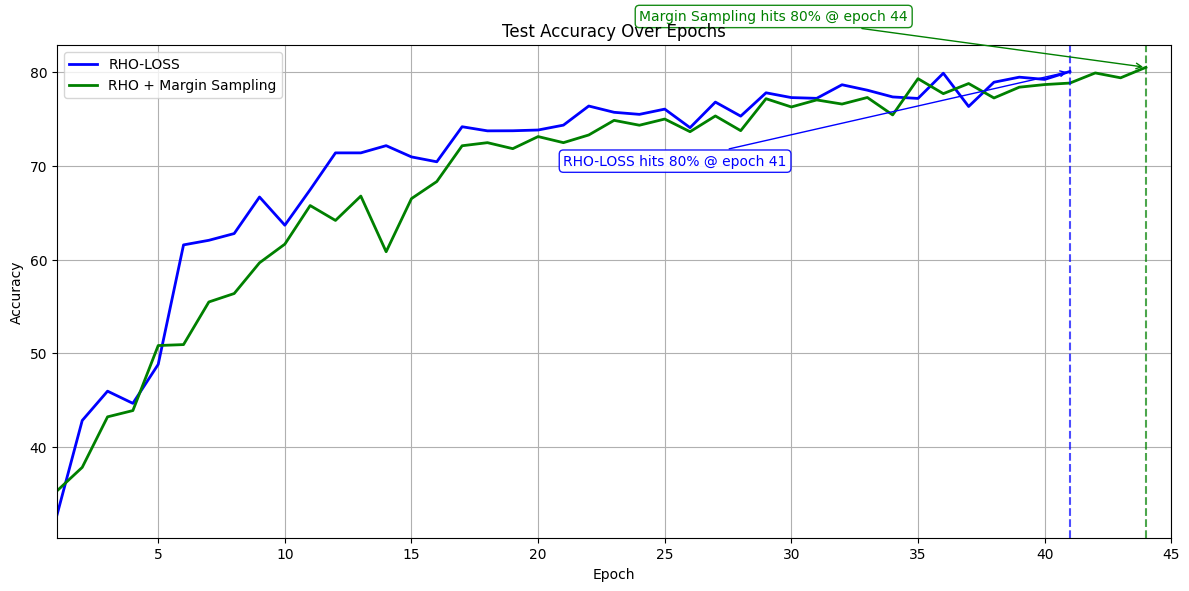

In [13]:
import matplotlib.pyplot as plt

# Sample data: Replace these with your actual accuracy values per epoch
rho_loss_acc = rho_accuracies # Length 41
margin_rho_acc = ma_accuracies  # Length 44

# Determine the maximum length
max_length = 45

# Pad the shorter list with None to match the maximum length
rho_loss_acc += [None] * (max_length - len(rho_loss_acc))
margin_rho_acc += [None] * (max_length - len(margin_rho_acc))

epochs = list(range(1, max_length + 1))

# Function to find the first epoch where accuracy >= 80%
def find_epoch(acc_list):
    for i, acc in enumerate(acc_list):
        if acc is not None and acc >= 80.0:
            return i + 1  # Epochs are 1-indexed
    return None

rho_epoch_80 = find_epoch(rho_loss_acc)
margin_epoch_80 = find_epoch(margin_rho_acc)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(epochs, rho_loss_acc, label='RHO-LOSS', color='blue', linewidth=2)
plt.plot(epochs, margin_rho_acc, label='RHO + Margin Sampling', color='green', linewidth=2)

# Highlight the 80% accuracy points
if rho_epoch_80:
    plt.axvline(x=rho_epoch_80, color='blue', linestyle='--', alpha=0.7)
    plt.annotate(f'RHO-LOSS hits 80% @ epoch {rho_epoch_80}',
                 xy=(rho_epoch_80, rho_loss_acc[rho_epoch_80 - 1]),
                 xytext=(rho_epoch_80 - 20, rho_loss_acc[rho_epoch_80 - 1] - 10),
                 arrowprops=dict(arrowstyle='->', color='blue'),
                 fontsize=10, color='blue',
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor='blue', facecolor='white', alpha=0.9))

if margin_epoch_80:
    plt.axvline(x=margin_epoch_80, color='green', linestyle='--', alpha=0.7)
    plt.annotate(f'Margin Sampling hits 80% @ epoch {margin_epoch_80}',
                 xy=(margin_epoch_80, margin_rho_acc[margin_epoch_80 - 1]),
                 xytext=(margin_epoch_80 - 20, margin_rho_acc[margin_epoch_80 - 1] + 5),
                 arrowprops=dict(arrowstyle='->', color='green'),
                 fontsize=10, color='green',
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor='green', facecolor='white', alpha=0.9))


# Set x-axis limit to 45
plt.xlim(1, max_length)

# Plot settings
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim(0.5, 0.9)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
